In [25]:
import numpy as np
import pandas as pd
from astropy import wcs
from astropy.io import fits
import matplotlib.pyplot as plt

In [63]:
# Define path to data
data_path = '/Volumes/ES-HDD-Documents/Documents/matlas_dwarfs'

# Load fits sky as Numpy and Header
with fits.open(f'{data_path}/NGC4249.l.r.Mg004.fits') as hdul:
    
    primary_hdu = hdul[0]
    data = primary_hdu.data  # This is a NumPy array
    header = primary_hdu.header  # This is a FITS header object

# Load center position of Dwarfs in RA and DEC
df = pd.read_csv(f'{data_path}/annotations_dwarfs_MATLAS.csv')
ra_dwarf, dec_dwarf = df['center_ra'], df['center_dec']


In [67]:
# Get the pixel corners of the image
x_pixels, y_pixels = data.shape
pixel_corners = np.array([[0,0],[x_pixels, y_pixels]])

# Get the world corners (RA and DEC) of the image
w = wcs.WCS(header)
world_corners = w.wcs_pix2world(pixel_corners, 0)
ra_min, ra_max = world_corners[:,0].min(), world_corners[:,0].max()
dec_min, dec_max = world_corners[:,1].min(), world_corners[:,1].max()

In [133]:
dwarf_ra_in = (ra_min <= ra_dwarf) & (ra_dwarf <= ra_max)
dwarf_dec_in = (dec_min <= dec_dwarf) & (dec_dwarf <= dec_max)
dwarf_arg_in = dwarf_ra_in * dwarf_dec_in

In [134]:
dwarf_in = np.concatenate((ra_dwarf.to_numpy()[dwarf_arg_in, None], dec_dwarf.to_numpy()[dwarf_arg_in, None]), axis=1)

In [178]:
# Get dwarfs coordinates in pixels
dwarf_x_pixel, dwarf_y_pixel = w.wcs_world2pix(dwarf_in, 0).astype(int).T


In [232]:
dwarf_map = np.zeros_like(data)
dwarf_map[dwarf_x_pixel,dwarf_y_pixel] = 1

In [281]:
all_x_init = np.arange(0, x_pixels, size)
all_y_init = np.arange(0, y_pixels, size)

data_patch = np.zeros( ((len(all_x_init)-1)*(len(all_y_init-1)),1, size, size) )
dwarf_patch = np.zeros( data_patch.shape)

idx = 0
for index, i in enumerate(all_x_init):
    for jndex, j in enumerate(all_y_init):
        if jndex<len(all_y_init)-1 and index<len(all_x_init)-1:
            data_patch[idx] = data[i:all_x_init[index+1], j:all_y_init[jndex+1]]
            dwarf_patch[idx] = dwarf_map[i:all_x_init[index+1], j:all_y_init[jndex+1]]
            idx += 1

keep_patch = np.sum( data_patch, axis=(1,2,3) ) != 0
data_save  = data_patch[keep_patch]
dwarf_save = dwarf_patch[keep_patch]

In [290]:
np.where( np.sum( dwarf_patch, axis=(1,2,3) ) != 0)[0].shape

(69,)

In [295]:
np.argmax( np.sum( dwarf_patch, axis=(1,2,3) ) )

12878

In [299]:
data_patch[12878,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

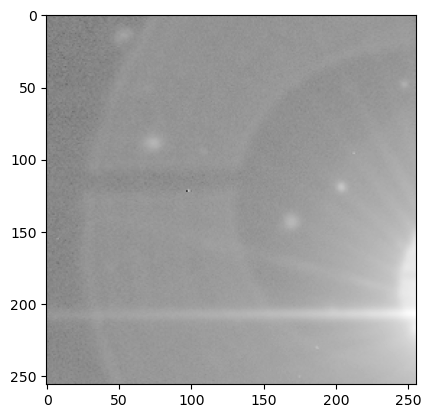

In [279]:
plt.imshow(np.arcsinh( data_save[-103,0]), cmap='gray' )

In [242]:
segmentation_patches.shape

torch.Size([105, 1, 1, 256, 34260])

In [228]:
# Get random patch of 256x256 pixels
size = 256
batch_size = 4
x_init = np.random.randint(size, x_pixels - size, batch_size)
y_init = np.random.randint(size, y_pixels - size, batch_size)

a = np.sign(np.random.uniform(-1, 1))
b = np.sign(np.random.uniform(-1, 1))

if a == 1:
    x_start = x_init
    x_end = x_init + size
else:
    x_start = x_init - size
    x_end = x_init

if b == 1:
    y_start = y_init
    y_end = y_init + size
else:
    y_start = y_init - size
    y_end = y_init

x_in = (x_start[:, None] <= dwarf_x_pixel[None, :]) & (dwarf_x_pixel[None, :] <= x_end[:, None])
y_in = (y_start[:, None] <= dwarf_y_pixel[None, :]) & (dwarf_y_pixel[None, :] <= y_end[:, None])
in_in = x_in * y_in

input = data[x_start:x_end, y_start:y_end]
label = np.zeros((size, size))
if x_in.sum() != 0:
    label[dwarf_x_pixel[in_in] - x_start, dwarf_y_pixel[in_in] - y_start] = 1

# plt.figure(figsize=(15, 10))
# plt.subplot(1,2,1)
# if input.max() == 0:
#     plt.imshow(input, cmap='gray')
# else:
#     plt.imshow(input, cmap='gray', norm='log')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(label, cmap='gray')
# plt.title(f'{label.sum()}')
# plt.axis('off');

TypeError: only integer scalar arrays can be converted to a scalar index

In [182]:
len(dwarf_in) / x_pixels * y_pixels

88.71051268772658